# Мобильные приложения — Выделение групп пользователей на основе поведения

<b> Задачи: </b>

1. Провести исследовательский анализ данных:
    - загрузка данных,
    - предобработка данных,
    - первичный анализ данных.  
       

2. Выделить группы пользователей, которые различаются по метрикам:
    - retention rate,
    - время, проведённое в приложении, 
    - частота действий, 
    - конверсия в целевое действие — просмотр контактов.
    

3. Сегментировать пользователей на основе действий.


4. Ответить на основные задачи исследования:
    - Пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?
    - Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?


5. Проверить статистические гипотезы:
    - Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.
    - Пользователи заходят в приложение в разные дни недели, в будние и в выходные дни. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.

<b> Описание данных: </b>

Для анализа предоставлены 2 датасета, содержащищ данные о событиях, совершенных в мобильном приложении "Ненужные вещи" (после 7 октября 2019 года). В приложении пользователи продают свои ненужные вещи, размещая их на доске объявлений.

Датасет **[mobile_dataset.csv](https://disk.yandex.ru/d/KaN8Wffo4Q510Q)** содержит колонки:
- `event.time` — время совершения
- `event.name` — название события
- `user.id` — идентификатор пользователя

Датасет **[mobile_sources.csv](https://disk.yandex.ru/d/RkfgQSEt-zD6Uw)** содержит колонки:
- `userId` — идентификатор пользователя
- `source` — источник, с которого пользователь установил приложение

Расшифровки событий:

- `advert_open` — открытие карточки объявления
- `photos_show` — просмотр фотографий в объявлении
- `tips_show` — пользователь увидел рекомендованные объявления
- `tips_click` — пользователь кликнул по рекомендованному объявлению
- `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
- `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
- `map` — пользователь открыл карту размещенных объявлений
- `search_1` — `search_7` — разные события, связанные с поиском по сайту
- `favorites_add` — добавление объявления в избранное

## Исследовательский анализ данных

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

pd.options.mode.chained_assignment = None

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [4]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [5]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


In [6]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


<b> Вывод: </b>

Данные загружены, готовы к предобработке.

### Предобработка данных

In [7]:
# перименуем название столбцов
mobile_sourсes.rename(columns = {'userId':'user_id'}, inplace = True)

In [8]:
# перименуем название столбцов
mobile_dataset.columns = ['event_time', 'event_name', 'user_id']

In [9]:
# поиск дубликатов
mobile_sourсes.duplicated().sum()

0

In [10]:
# поиск дубликатов
mobile_dataset.duplicated().sum()

0

In [11]:
# поиск пропусков
mobile_sourсes.isna().sum()

user_id    0
source     0
dtype: int64

In [12]:
# поиск пропусков
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

In [13]:
# посчитаем количество событий
mobile_dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

In [14]:
# названия contacts_show и show_contacts обозначают одно и то же событие. оставим только contacts_show
mobile_dataset["event_name"] = mobile_dataset["event_name"].replace("show_contacts", "contacts_show")

In [15]:
# преобразуем данные о времени
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])

In [16]:
# добавим информацию о дне
mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date

In [17]:
# объединим таблицы
df = mobile_dataset.merge(mobile_sourсes, on='user_id', how='left')
df

,event_time,event_name,user_id,event_date,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,other
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,yandex
...,...,...,...,...,...
74192,2019-11-03 23:53:29.534986,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,google
74193,2019-11-03 23:54:00.407086,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,google
74194,2019-11-03 23:56:57.041825,search_1,20850c8f-4135-4059-b13b-198d3ac59902,2019-11-03,google
74195,2019-11-03 23:57:06.232189,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9,2019-11-03,google


In [18]:
# снова проверим на дубликаты
df.duplicated().sum()

0

<b> Вывод: </b>

Данные предобработаны и готовы к первичному анализу:
- Дубликаты и пропуски отсутствуют. 
- Названия столбцов приведены к удобному виду. 
- Данные о времени преобразованы.
- Таблицы объеденены в одну.

### Первичный анализ данных

In [19]:
# посмотрим, за какой период предоставлены данные
print(mobile_dataset['event_time'].min(), ' - ', mobile_dataset['event_time'].max())

2019-10-07 00:00:00.431357  -  2019-11-03 23:58:12.532487


In [20]:
# количество уникальных пользователей
df['user_id'].nunique()

4293

In [21]:
# количество уникальных пользователей по источникам (создадим временную табличку)
t = df.groupby('source')['user_id'].nunique().sort_values(ascending=False).reset_index()
t.columns = ['source', 'cnt']
t

,source,cnt
0,yandex,1934
1,other,1230
2,google,1129


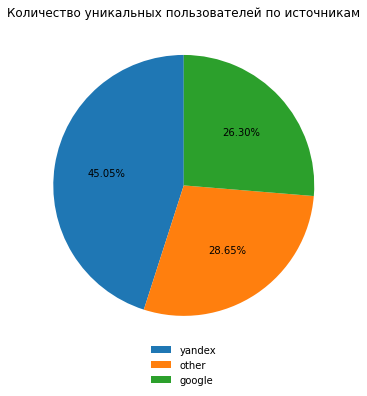

In [22]:
# построим круговую диаграмму 
plt.figure(figsize = (10,6))
plt.pie(t['cnt'], startangle=90, autopct='%.2f%%')
plt.title('Количество уникальных пользователей по источникам')
plt.legend(labels=["yandex", "other", "google"], 
           loc='center', bbox_to_anchor=(0.5, -0.05), frameon=False)
plt.show()

In [23]:
# количество пользователей, совершивших событие (создадим временную табличку)
t = df.groupby('event_name')['user_id'].count().sort_values(ascending=False).reset_index()
t

,event_name,user_id
0,tips_show,40055
1,photos_show,10012
2,advert_open,6164
3,contacts_show,4529
4,map,3881
5,search_1,3506
6,favorites_add,1417
7,search_5,1049
8,tips_click,814
9,search_4,701


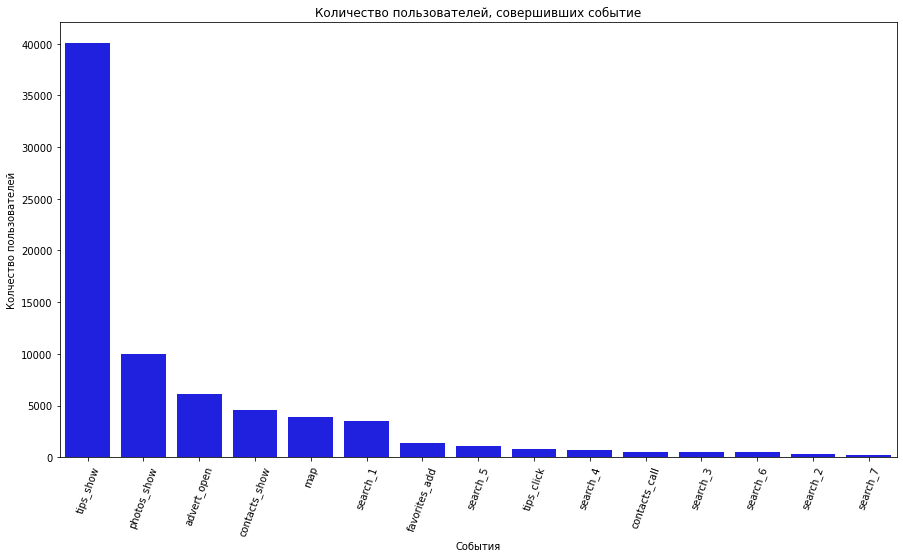

In [24]:
# построим диаграмму 
plt.figure(figsize = (15,8))
sns.barplot(x='event_name', y='user_id', data=t, color='blue')
plt.xticks(rotation=70)
plt.xlabel('События')
plt.ylabel('Колчество пользователей')
plt.title('Количество пользователей, совершивших событие')
plt.show()

In [25]:
# распределение событий по времени (создадим временную табличку) 
t = df.groupby('event_date')['event_name'].count().reset_index()
t

,event_date,event_name
0,2019-10-07,2545
1,2019-10-08,2499
2,2019-10-09,2027
3,2019-10-10,2243
4,2019-10-11,2030
5,2019-10-12,1843
6,2019-10-13,2635
7,2019-10-14,3034
8,2019-10-15,2722
9,2019-10-16,2730


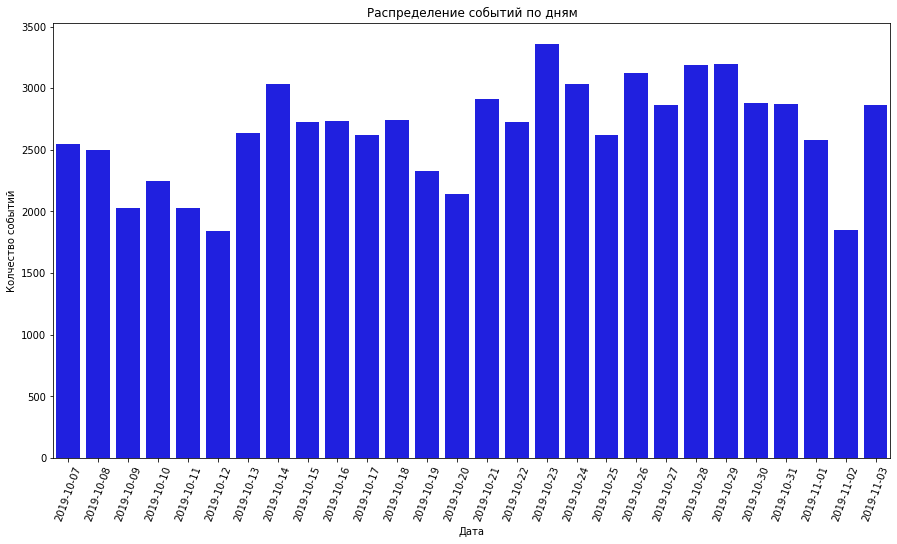

In [26]:
# построим диаграмму 
plt.figure(figsize = (15,8))
sns.barplot(x='event_date', y='event_name', data=t, color='blue')
plt.xticks(rotation=70)
plt.xlabel('Дата')
plt.ylabel('Колчество событий')
plt.title('Распределение событий по дням')
plt.show()

<b> Вывод: </b>

Данные предоставлены за период с 07.10.2019 по 03.11.2019 (чуть меньше месяца).

Количество уникальных пользователей приложения за этот период – 4293 человека.

Почти половина пользователей приходят в приложение через Yandex. Google и «прочие источники» составляют вторую половину и незначительно различаются между собой.

Что касается событий, то самое частое событие это - пользователь увидел рекомендованные объявления. Следом идёт - просмотр фотографий в объявлении. За ним - открытие карточки объявления.

События распределены по дням достаточно равномерно. 

<b> Общий вывод по разделу 1: </b>

Данные загружены и предобработаны. Проведён первичный анализ. Можно переходить к следующей задаче.

## Выделим группы пользователей, которые различаются по метрикам:
- retention rate,
- время, проведённое в приложении,
- частота действий,
- конверсия в целевое действие — просмотр контактов.

### Retention rate

In [27]:
# отсортируем датасет по user_id и event_time
df = df.sort_values(by=['user_id', 'event_time']).reset_index()
df

,index,event_time,event_name,user_id,event_date,source
0,805,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
1,806,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
2,809,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
3,820,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
4,830,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,other
...,...,...,...,...,...,...
74192,72584,2019-11-03 15:51:23.959572,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google
74193,72589,2019-11-03 15:51:57.899997,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google
74194,72684,2019-11-03 16:07:40.932077,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google
74195,72688,2019-11-03 16:08:18.202734,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-03,google


In [28]:
# получим профайлы пользователей
profiles = (
    df.groupby('user_id')
    .agg({'event_time': 'first', 'source': 'first'})
    .rename(columns={'event_time': 'first_event_time'})
    .reset_index()
)

# выделим дату
profiles['first_event_date'] = profiles['first_event_time'].dt.date

profiles

,user_id,first_event_time,source,first_event_date
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,yandex,2019-10-19
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,yandex,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,google,2019-10-18
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,yandex,2019-10-25
...,...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2019-10-13 16:11:27.414960,yandex,2019-10-13
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,2019-10-07 20:32:49.997044,yandex,2019-10-07
4290,ffcf50d9-293c-4254-8243-4890b030b238,2019-10-23 11:51:35.199237,google,2019-10-23
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,2019-10-21 16:39:33.867145,yandex,2019-10-21


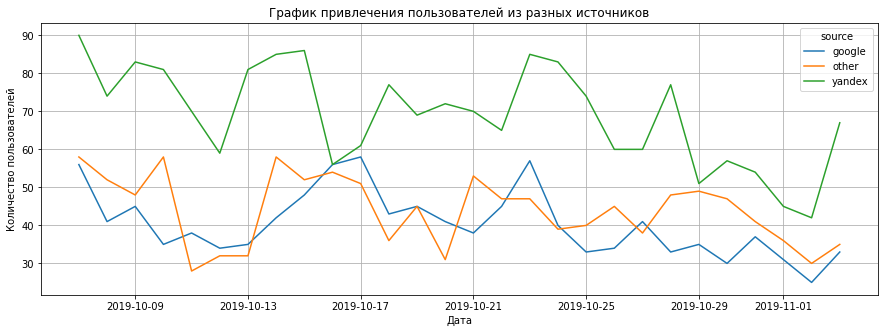

In [29]:
# построим график привлечения пользователей из разных источников
profiles.pivot_table(
    index='first_event_date',
    columns='source',
    values='user_id',
    aggfunc='nunique'
).plot(figsize=(15, 5), grid=True)

plt.title('График привлечения пользователей из разных источников') 
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')

plt.show()

In [30]:
# объединим профайлы с дотасетом
df = profiles.merge(df[['user_id', 'event_time', 'event_name']], on='user_id', how='left')
df

,user_id,first_event_time,source,first_event_date,event_time,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:39:45.989359,tips_show
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:40:31.052909,tips_show
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:41:05.722489,tips_show
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:43:20.735461,tips_show
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:45:30.917502,tips_show
...,...,...,...,...,...,...
74192,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 15:51:23.959572,tips_show
74193,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 15:51:57.899997,contacts_show
74194,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 16:07:40.932077,tips_show
74195,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 16:08:18.202734,tips_show


In [31]:
# посчитаем лайфтайм в днях
df['lifetime'] = (df['event_time'] - df['first_event_time']).dt.days
df

,user_id,first_event_time,source,first_event_date,event_time,event_name,lifetime
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:39:45.989359,tips_show,0
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:40:31.052909,tips_show,0
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:41:05.722489,tips_show,0
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:43:20.735461,tips_show,0
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,other,2019-10-07,2019-10-07 13:45:30.917502,tips_show,0
...,...,...,...,...,...,...,...
74192,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 15:51:23.959572,tips_show,22
74193,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 15:51:57.899997,contacts_show,22
74194,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 16:07:40.932077,tips_show,22
74195,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12 00:57:21.241896,google,2019-10-12,2019-11-03 16:08:18.202734,tips_show,22


In [32]:
# построим сводную таблицу по удержанию
t = df.pivot_table(index=['first_event_date'], columns='lifetime', values='user_id', aggfunc='nunique')
t

lifetime,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
first_event_date,,,,,,,,,,,,,,,,,,,,,
2019-10-07,204.0,25.0,20.0,22.0,11.0,8.0,12.0,16.0,11.0,10.0,...,4.0,9.0,5.0,3.0,4.0,7.0,7.0,8.0,9.0,6.0
2019-10-08,167.0,27.0,21.0,9.0,7.0,11.0,9.0,12.0,10.0,7.0,...,5.0,3.0,8.0,6.0,3.0,4.0,7.0,5.0,4.0,2.0
2019-10-09,176.0,13.0,11.0,10.0,12.0,12.0,10.0,13.0,11.0,6.0,...,3.0,2.0,5.0,2.0,6.0,2.0,1.0,4.0,3.0,NaN
2019-10-10,174.0,16.0,18.0,14.0,17.0,14.0,12.0,9.0,14.0,6.0,...,11.0,6.0,5.0,3.0,7.0,3.0,2.0,2.0,NaN,NaN
2019-10-11,136.0,12.0,16.0,13.0,12.0,10.0,10.0,6.0,2.0,6.0,...,8.0,4.0,3.0,3.0,4.0,4.0,2.0,NaN,NaN,NaN
2019-10-12,125.0,16.0,20.0,7.0,8.0,11.0,10.0,11.0,10.0,8.0,...,5.0,5.0,3.0,3.0,8.0,4.0,NaN,NaN,NaN,NaN
2019-10-13,148.0,19.0,10.0,8.0,10.0,8.0,8.0,7.0,7.0,7.0,...,2.0,3.0,2.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN
2019-10-14,185.0,21.0,19.0,19.0,15.0,13.0,10.0,8.0,14.0,7.0,...,7.0,4.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,186.0,26.0,17.0,15.0,10.0,10.0,15.0,14.0,12.0,4.0,...,6.0,5.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# посчитаем размеры когорт по дням
cohort_sizes = df.groupby('first_event_date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

# присоединим размеры когорт к сводной таблице
t = cohort_sizes.merge(t, on='first_event_date', how='left').fillna(0)

# посчитаем коэффициенты удержания
t = round(t.div(t['cohort_size'], axis=0), 2)
t

,cohort_size,0,1,2,3,4,5,6,7,8,...,17,18,19,20,21,22,23,24,25,26
first_event_date,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,1.0,0.12,0.10,0.11,0.05,0.04,0.06,0.08,0.05,...,0.02,0.04,0.02,0.01,0.02,0.03,0.03,0.04,0.04,0.03
2019-10-08,1.0,1.0,0.16,0.13,0.05,0.04,0.07,0.05,0.07,0.06,...,0.03,0.02,0.05,0.04,0.02,0.02,0.04,0.03,0.02,0.01
2019-10-09,1.0,1.0,0.07,0.06,0.06,0.07,0.07,0.06,0.07,0.06,...,0.02,0.01,0.03,0.01,0.03,0.01,0.01,0.02,0.02,0.00
2019-10-10,1.0,1.0,0.09,0.10,0.08,0.10,0.08,0.07,0.05,0.08,...,0.06,0.03,0.03,0.02,0.04,0.02,0.01,0.01,0.00,0.00
2019-10-11,1.0,1.0,0.09,0.12,0.10,0.09,0.07,0.07,0.04,0.01,...,0.06,0.03,0.02,0.02,0.03,0.03,0.01,0.00,0.00,0.00
2019-10-12,1.0,1.0,0.13,0.16,0.06,0.06,0.09,0.08,0.09,0.08,...,0.04,0.04,0.02,0.02,0.06,0.03,0.00,0.00,0.00,0.00
2019-10-13,1.0,1.0,0.13,0.07,0.05,0.07,0.05,0.05,0.05,0.05,...,0.01,0.02,0.01,0.03,0.01,0.00,0.00,0.00,0.00,0.00
2019-10-14,1.0,1.0,0.11,0.10,0.10,0.08,0.07,0.05,0.04,0.08,...,0.04,0.02,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00
2019-10-15,1.0,1.0,0.14,0.09,0.08,0.05,0.05,0.08,0.08,0.06,...,0.03,0.03,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00


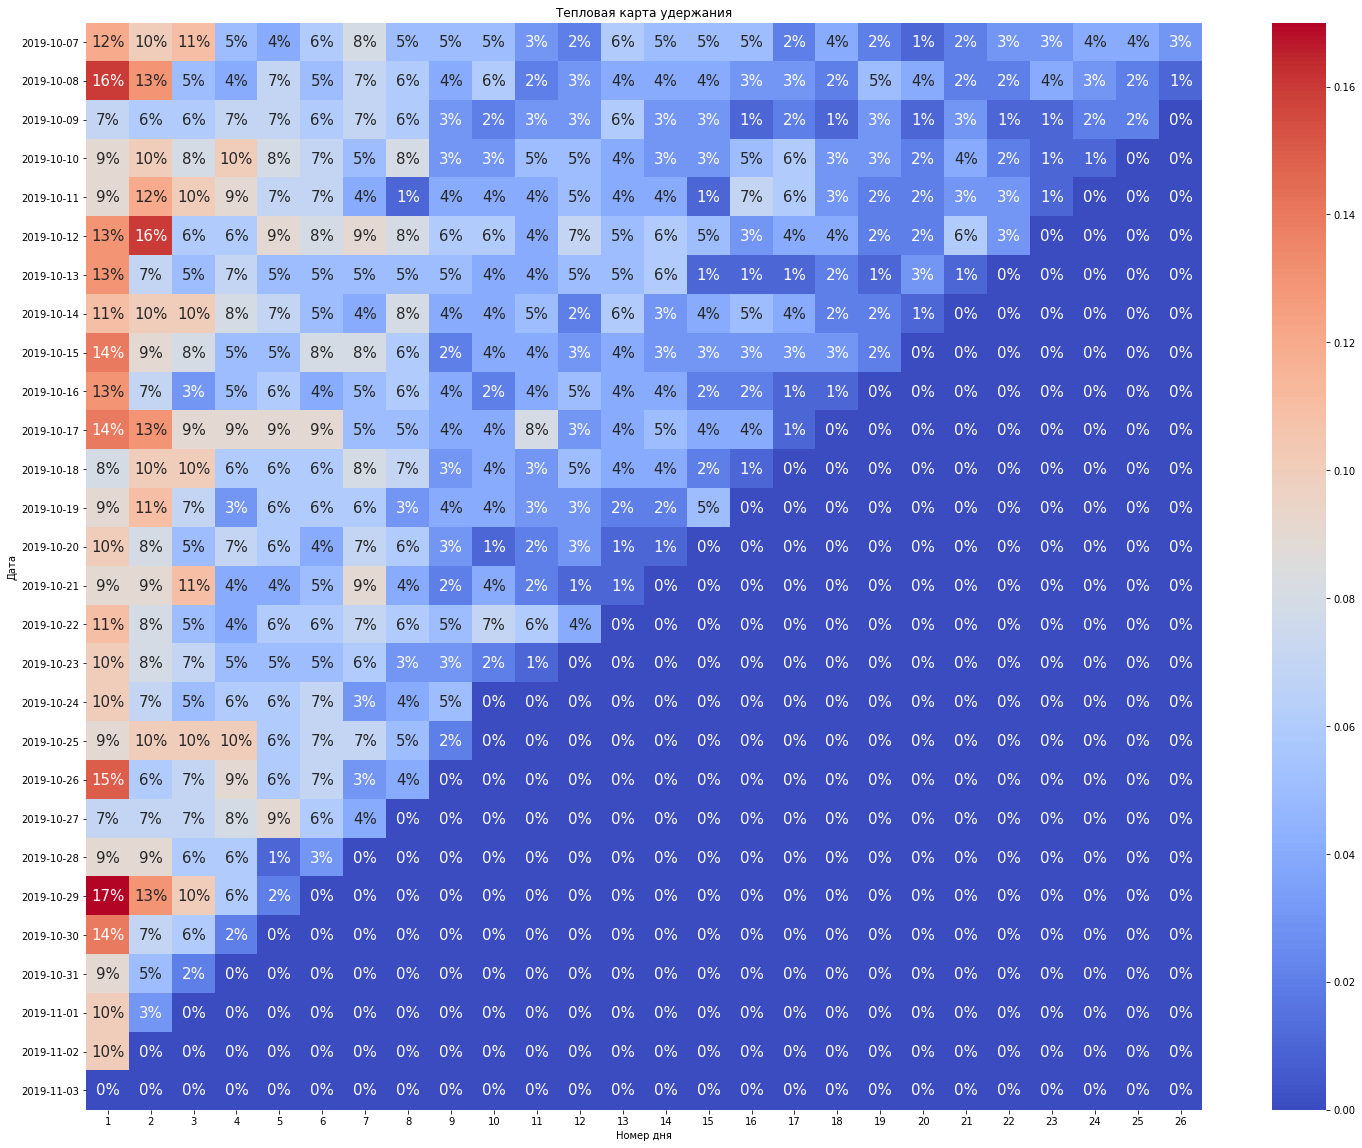

In [34]:
# построим тепловую карту
plt.figure(figsize=(25, 20))
sns.heatmap(t.drop(columns=['cohort_size', 0]),
            cmap='coolwarm',
            annot=True,
            annot_kws={'fontsize':15},
            fmt='.0%')
plt.title('Тепловая карта удержания') 
plt.xlabel('Номер дня')
plt.ylabel('Дата')
#sns.set(font_scale=5)
plt.show()

<b> Вывод: </b>

Хороший процент удержания отмечается только в первые дни использования приложения.

### Время, проведённое в приложении


In [35]:
# примем сессию равной календарному дню
df['session_date'] = df['event_time'].dt.date

In [36]:
# определили время первого и последнего события за день и количество событий
t = df.groupby(['user_id','session_date']).agg({'event_time':['min', 'max'], 'event_name':['first', 'last', 'count']}).reset_index()
t.columns = ['user_id','session', 'start', 'finish', 'first_event', 'last_event', 'count_event']
t['interval'] = (t.finish - t.start).dt.total_seconds()
t

,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,tips_show,tips_show,9,595.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,map,tips_show,4,507.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,tips_show,tips_show,14,899.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,map,tips_show,8,758.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,search_1,photos_show,9,1520.787329
...,...,...,...,...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47.865084,2019-10-29 16:13:00.681459,tips_show,contacts_show,20,8052.816375
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-30,2019-10-30 00:15:43.363752,2019-10-30 11:31:45.886946,contacts_show,tips_show,3,40562.523194
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31.162871,2019-11-01 00:24:53.473219,tips_show,tips_show,2,22.310348
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,2019-11-02 01:16:48.947231,2019-11-02 19:30:50.471310,tips_show,tips_show,7,65641.524079


In [37]:
# проверим на интервалы равные нулю
t['interval'].value_counts()

0.000000        994
53.668531         1
2501.645155       1
696.463315        1
1181.826832       1
               ... 
240.019246        1
10.567931         1
49461.391203      1
13905.534414      1
400.945286        1
Name: interval, Length: 6824, dtype: int64

In [38]:
# посмотрим на 1 действие за сессию 
t[t['count_event'] == 1]['first_event'].value_counts()

tips_show        392
photos_show      248
search_1         179
contacts_show     64
map               57
advert_open       25
search_5          10
favorites_add      9
tips_click         5
search_7           3
search_4           1
search_3           1
Name: first_event, dtype: int64

In [39]:
# уберём интервалы равные нулю, а также дни, в которых совершено только одно действие
t = t.query('count_event > 1 and interval !=0')
t

,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,tips_show,tips_show,9,595.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,map,tips_show,4,507.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,tips_show,tips_show,14,899.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,map,tips_show,8,758.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,search_1,photos_show,9,1520.787329
...,...,...,...,...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47.865084,2019-10-29 16:13:00.681459,tips_show,contacts_show,20,8052.816375
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-30,2019-10-30 00:15:43.363752,2019-10-30 11:31:45.886946,contacts_show,tips_show,3,40562.523194
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31.162871,2019-11-01 00:24:53.473219,tips_show,tips_show,2,22.310348
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,2019-11-02 01:16:48.947231,2019-11-02 19:30:50.471310,tips_show,tips_show,7,65641.524079


In [40]:
# проверим
t['interval'].sort_values()

3895        0.000181
399         0.010172
4651        0.012021
4894        0.012440
4901        0.024698
            ...     
7247    82802.247973
5531    83173.167359
6144    84426.071771
5663    84643.696890
660     85048.666352
Name: interval, Length: 6823, dtype: float64

In [41]:
# уберём интервалы меньше секунды
t = t.query('interval > 1')
t

,user_id,session,start,finish,first_event,last_event,count_event,interval
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,tips_show,tips_show,9,595.727258
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,map,tips_show,4,507.385985
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,tips_show,tips_show,14,899.272096
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,map,tips_show,8,758.171767
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,search_1,photos_show,9,1520.787329
...,...,...,...,...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47.865084,2019-10-29 16:13:00.681459,tips_show,contacts_show,20,8052.816375
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-30,2019-10-30 00:15:43.363752,2019-10-30 11:31:45.886946,contacts_show,tips_show,3,40562.523194
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31.162871,2019-11-01 00:24:53.473219,tips_show,tips_show,2,22.310348
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,2019-11-02 01:16:48.947231,2019-11-02 19:30:50.471310,tips_show,tips_show,7,65641.524079


In [42]:
t['interval'].describe()

count     6798.000000
mean      5728.788773
std      12059.400866
min          1.038815
25%        317.388326
50%       1001.240458
75%       3897.962388
max      85048.666352
Name: interval, dtype: float64

In [43]:
# посчитаем медианное время сессии
round(t['interval'].median() / 60, 2)

16.69

<b> Вывод: </b>

В среднем пользователи проводят в приложении 16 минут.

### Частота действий

In [44]:
# посчитаем частоту действий

t['periodicity'] = t['interval'] / t['count_event']
t

,user_id,session,start,finish,first_event,last_event,count_event,interval,periodicity
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-07 13:39:45.989359,2019-10-07 13:49:41.716617,tips_show,tips_show,9,595.727258,66.191918
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-09,2019-10-09 18:33:55.577963,2019-10-09 18:42:22.963948,map,tips_show,4,507.385985,126.846496
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-21,2019-10-21 19:52:30.778932,2019-10-21 20:07:30.051028,tips_show,tips_show,14,899.272096,64.233721
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-22,2019-10-22 11:18:14.635436,2019-10-22 11:30:52.807203,map,tips_show,8,758.171767,94.771471
4,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-10-19 21:34:33.849769,2019-10-19 21:59:54.637098,search_1,photos_show,9,1520.787329,168.976370
...,...,...,...,...,...,...,...,...,...
7812,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-29,2019-10-29 13:58:47.865084,2019-10-29 16:13:00.681459,tips_show,contacts_show,20,8052.816375,402.640819
7813,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-30,2019-10-30 00:15:43.363752,2019-10-30 11:31:45.886946,contacts_show,tips_show,3,40562.523194,13520.841065
7814,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-01,2019-11-01 00:24:31.162871,2019-11-01 00:24:53.473219,tips_show,tips_show,2,22.310348,11.155174
7815,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-11-02,2019-11-02 01:16:48.947231,2019-11-02 19:30:50.471310,tips_show,tips_show,7,65641.524079,9377.360583


In [45]:
t['periodicity'].describe()

count     6798.000000
mean       740.592922
std       2199.912822
min          0.173136
25%         55.937123
50%        117.289774
75%        356.859689
max      41586.583679
Name: periodicity, dtype: float64

In [46]:
# посчитаем медианную частоту
round(t['periodicity'].median() / 60, 2)

1.95

<b> Вывод: </b>

В среднем пользователи совершают действия раз в 2 минуты.

### Конверсия в целевое действие — просмотр контактов

In [47]:
# создадим временную табличку
t = df.groupby('event_name')['user_id'].nunique().sort_values(ascending=False).to_frame(name='cnt').reset_index()
t

,event_name,cnt
0,tips_show,2801
1,map,1456
2,photos_show,1095
3,contacts_show,981
4,search_1,787
5,advert_open,751
6,search_5,663
7,search_4,474
8,favorites_add,351
9,search_6,330


In [48]:
# конверсия
round((t.loc[(t['event_name'] == 'contacts_show')].iloc[0]['cnt'] / df['user_id'].nunique()) * 100, 2)

22.85

<b> Вывод: </b>

Количество пользователей, совершивших целевое действие - contacts_show - 981 человек.

Конверсия 23 %.

<b> Общий вывод по разделу 2: </b>

Хороший процент удержания пользователей отмечается только в первые дни использования приложения.
Лучший показатель по retention rate у пользователей, пришедших с помощью yandex.

В среднем пользователи проводят в приложении 16 минут и совершают действия раз в 2 минуты.

Количество пользователей, совершивших целевое действие - contacts_show 981 человек.

## Сегментация пользователей на основе действий

Поделим пользователей на группы, исходя из источника, с которого пользователь установил приложение.

На основе данной сегментации можно будет рассмотреть, пользователи, пришедшие из какого источника чаще совершают целевое действие - contacts_show. На основании этого, можно будет решить, в рекламу на каком источнике стоит вкладывать больше денег. 

In [49]:
group_y = df.query('source == "yandex"')
group_g = df.query('source == "google"')
group_o = df.query('source == "other"')

<b> Общий вывод по разделу 3: </b>

Пользователи сегментированы.

## Ответим на основные задачи исследования:
- Пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?
- Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

### Пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?

#### group_y

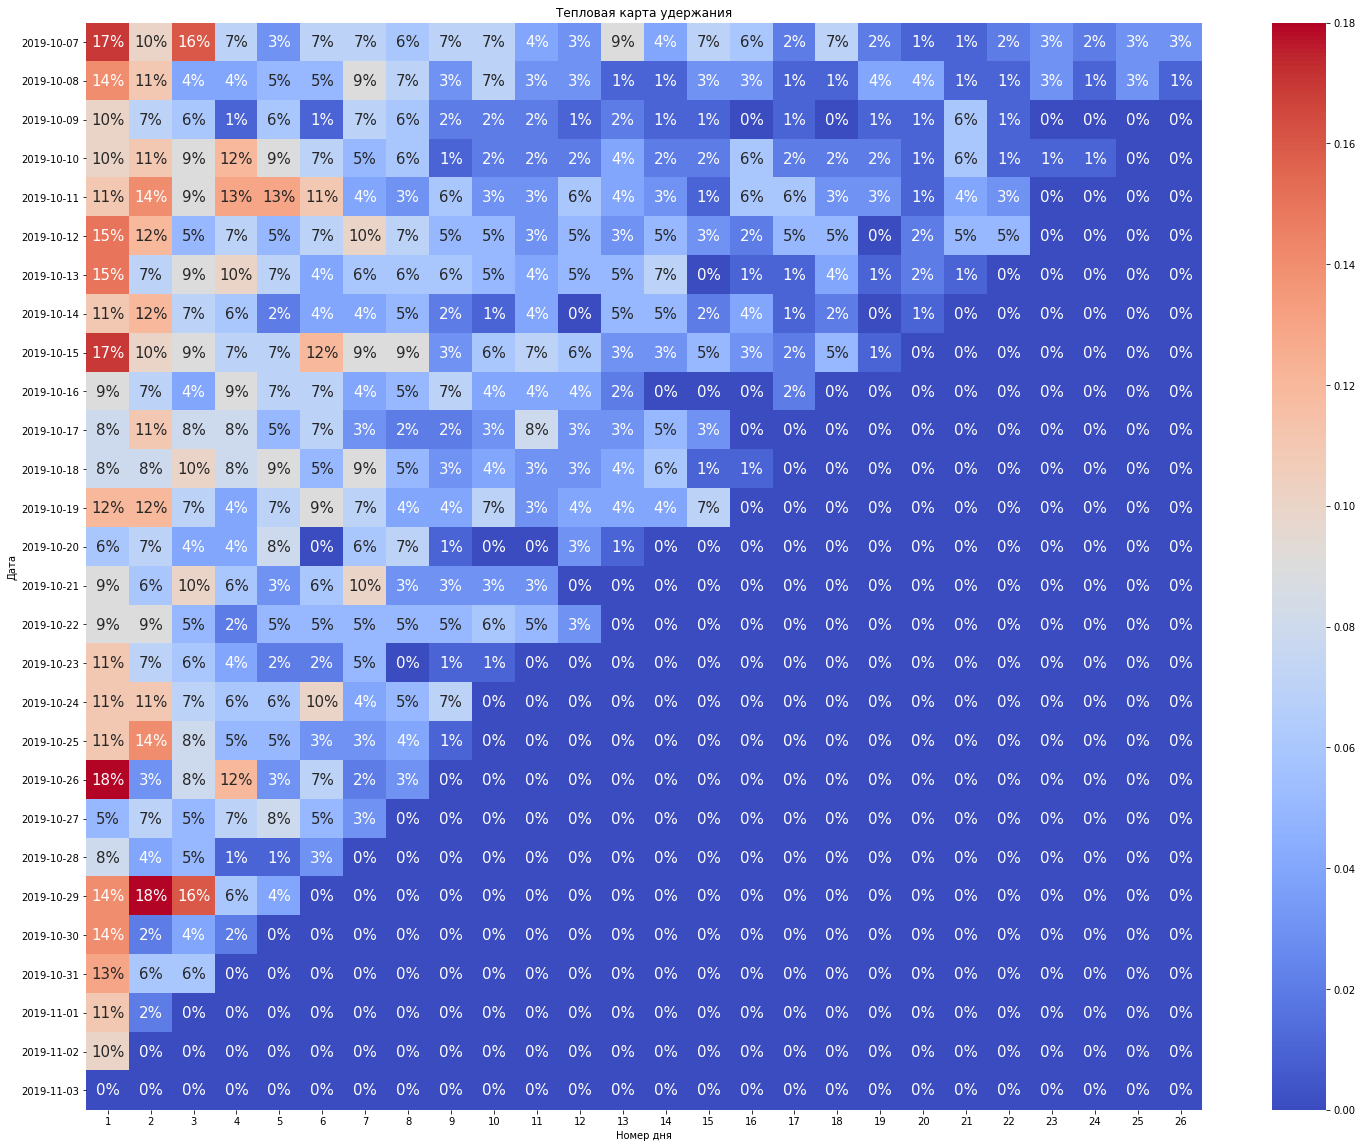

In [50]:
# отсортируем датасет по user_id и event_time
group_y = group_y.sort_values(by=['user_id', 'event_time']).reset_index()

# получим профайлы пользователей
profiles_y = (
    group_y.groupby('user_id')
    .agg({'event_time': 'first', 'source': 'first'})
    .rename(columns={'event_time': 'first_event_time'})
    .reset_index()
)

# выделим дату
profiles_y['first_event_date'] = profiles_y['first_event_time'].dt.date

# объединим профайлы с дотасетом
group_y = profiles_y.merge(group_y[['user_id', 'event_time', 'event_name']], on='user_id', how='left')

# посчитаем лайфтайм в днях
group_y['lifetime'] = (group_y['event_time'] - group_y['first_event_time']).dt.days

# построим сводную таблицу по удержанию
t_y = group_y.pivot_table(index=['first_event_date'], columns='lifetime', values='user_id', aggfunc='nunique')

# посчитаем размеры когорт по дням
cohort_sizes_y = group_y.groupby('first_event_date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

# присоединим размеры когорт к сводной таблице
t_y = cohort_sizes_y.merge(t_y, on='first_event_date', how='left').fillna(0)

# посчитаем коэффициенты удержания
t_y = round(t_y.div(t_y['cohort_size'], axis=0), 2)

# построим тепловую карту
plt.figure(figsize=(25, 20))
sns.heatmap(t_y.drop(columns=['cohort_size', 0]),
            cmap='coolwarm',
            annot=True,
            annot_kws={'fontsize':15},
            fmt='.0%')
plt.title('Тепловая карта удержания') 
plt.xlabel('Номер дня') 
plt.ylabel('Дата')
#sns.set(font_scale=20)
plt.show()

#### group_g

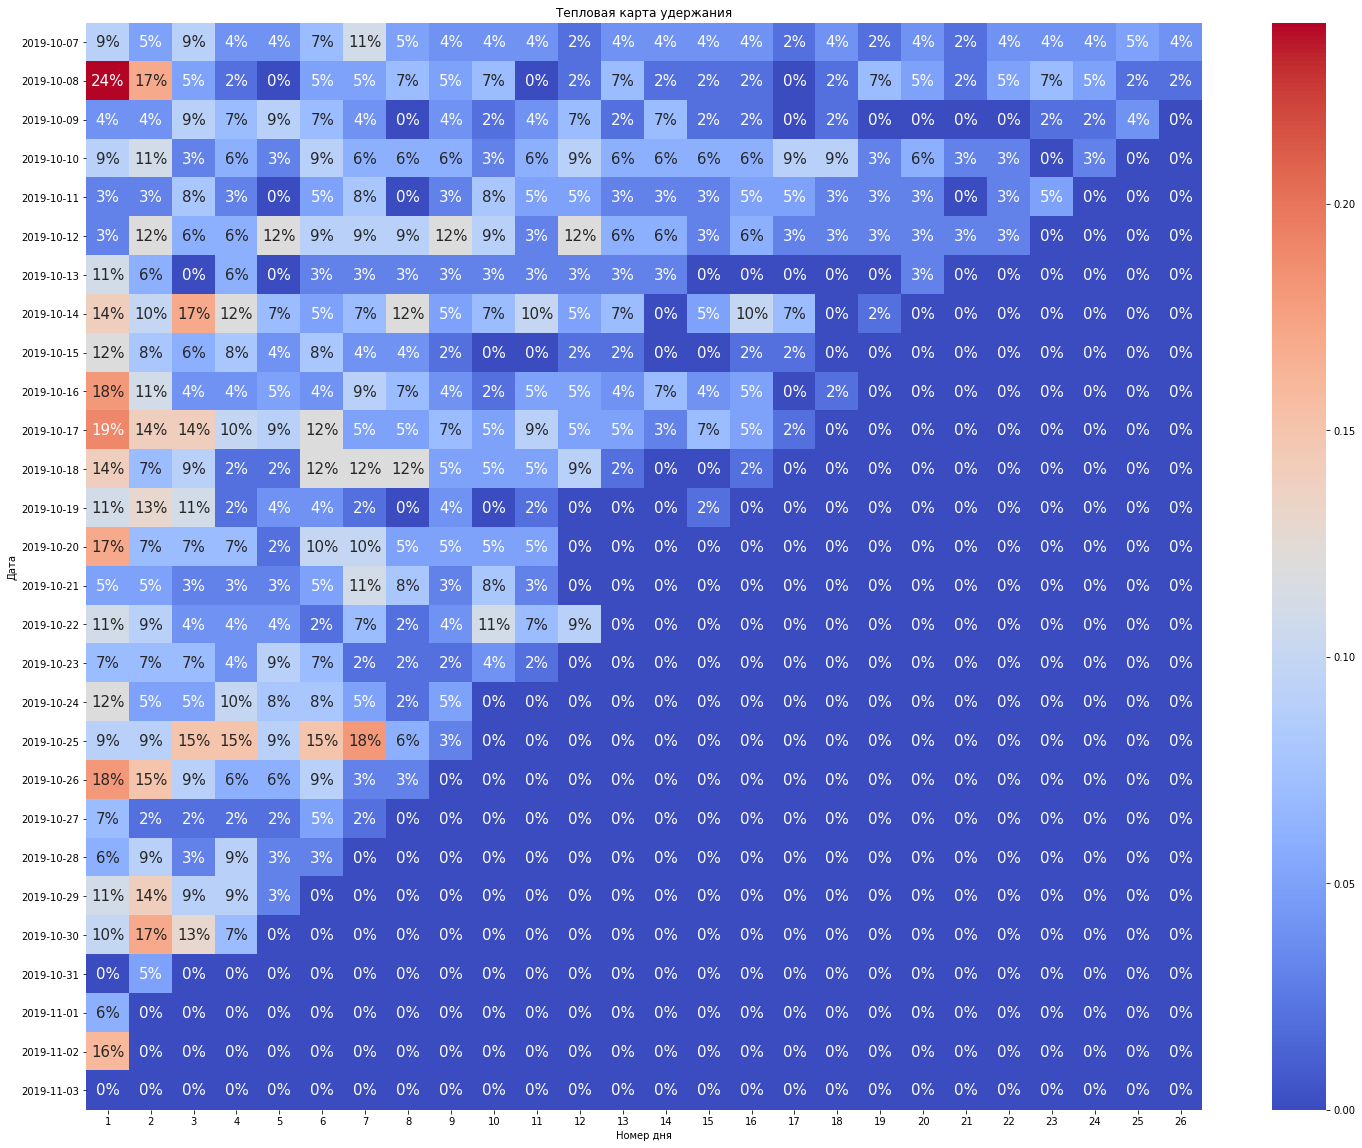

In [51]:
# отсортируем датасет по user_id и event_time
group_g = group_g.sort_values(by=['user_id', 'event_time']).reset_index()

# получим профайлы пользователей
profiles_g = (
    group_g.groupby('user_id')
    .agg({'event_time': 'first', 'source': 'first'})
    .rename(columns={'event_time': 'first_event_time'})
    .reset_index()
)

# выделим дату
profiles_g['first_event_date'] = profiles_g['first_event_time'].dt.date

# объединим профайлы с дотасетом
group_g = profiles_g.merge(group_g[['user_id', 'event_time', 'event_name']], on='user_id', how='left')

# посчитаем лайфтайм в днях
group_g['lifetime'] = (group_g['event_time'] - group_g['first_event_time']).dt.days

# построим сводную таблицу по удержанию
t_g = group_g.pivot_table(index=['first_event_date'], columns='lifetime', values='user_id', aggfunc='nunique')

# посчитаем размеры когорт по дням
cohort_sizes_g = group_g.groupby('first_event_date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

# присоединим размеры когорт к сводной таблице
t_g = cohort_sizes_g.merge(t_g, on='first_event_date', how='left').fillna(0)

# посчитаем коэффициенты удержания
t_g = round(t_g.div(t_g['cohort_size'], axis=0), 2)

# построим тепловую карту
plt.figure(figsize=(25, 20))
sns.heatmap(t_g.drop(columns=['cohort_size', 0]),
            cmap='coolwarm',
            annot=True,
            annot_kws={'fontsize':15},
            fmt='.0%')
plt.title('Тепловая карта удержания') 
plt.xlabel('Номер дня') 
plt.ylabel('Дата')
#sns.set(font_scale=20)
plt.show()

#### group_o

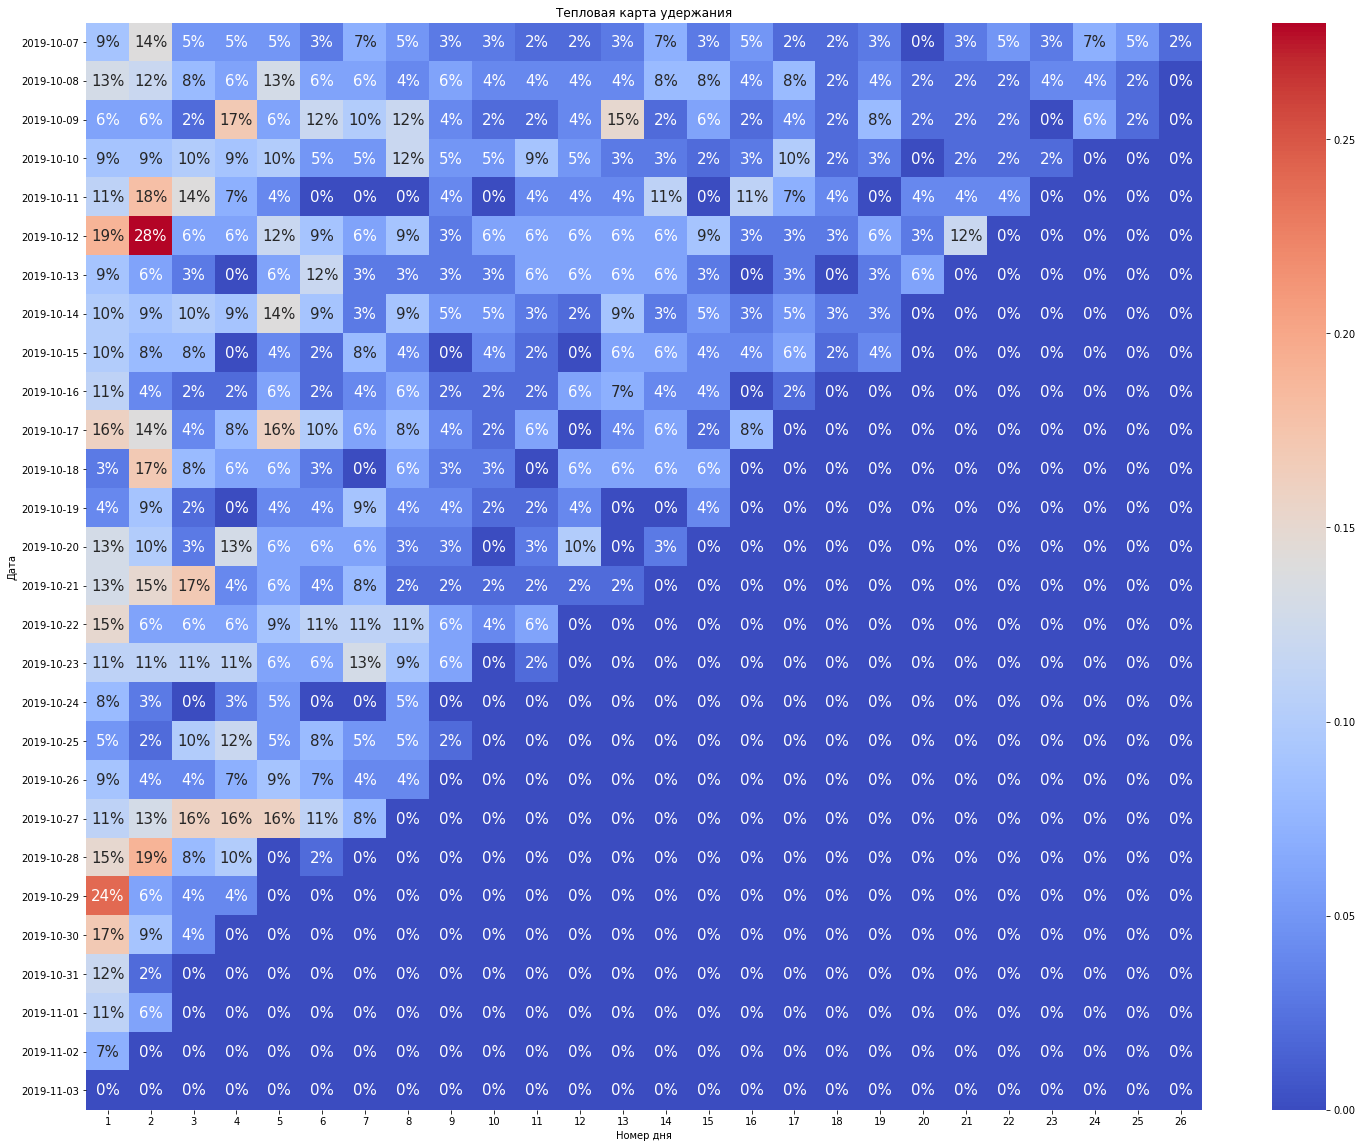

In [52]:
# отсортируем датасет по user_id и event_time
group_o = group_o.sort_values(by=['user_id', 'event_time']).reset_index()

# получим профайлы пользователей
profiles_o = (
    group_o.groupby('user_id')
    .agg({'event_time': 'first', 'source': 'first'})
    .rename(columns={'event_time': 'first_event_time'})
    .reset_index()
)

# выделим дату
profiles_o['first_event_date'] = profiles_o['first_event_time'].dt.date

# объединим профайлы с дотасетом
group_o = profiles_o.merge(group_o[['user_id', 'event_time', 'event_name']], on='user_id', how='left')

# посчитаем лайфтайм в днях
group_o['lifetime'] = (group_o['event_time'] - group_o['first_event_time']).dt.days

# построим сводную таблицу по удержанию
t_o = group_o.pivot_table(index=['first_event_date'], columns='lifetime', values='user_id', aggfunc='nunique')

# посчитаем размеры когорт по дням
cohort_sizes_o = group_o.groupby('first_event_date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})

# присоединим размеры когорт к сводной таблице
t_o = cohort_sizes_o.merge(t_o, on='first_event_date', how='left').fillna(0)

# посчитаем коэффициенты удержания
t_o = round(t_o.div(t_o['cohort_size'], axis=0), 2)

# построим тепловую карту
plt.figure(figsize=(25, 20))
sns.heatmap(t_o.drop(columns=['cohort_size', 0]),
            cmap='coolwarm',
            annot=True,
            annot_kws={'fontsize':15},
            fmt='.0%')
plt.title('Тепловая карта удержания') 
plt.xlabel('Номер дня') 
plt.ylabel('Дата')
#sns.set(font_scale=20)
plt.show()

<b> Вывод: </b>


Пользователи, установившие приложение из источника yandex, чаще склонны возвращаться в мобильное приложение.

### Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

#### group_y

In [53]:
# создадим временную табличку
t_y = (
    df[df['source'] == 'yandex']
    .groupby('event_name')['user_id'].nunique()
    .sort_values(ascending=False)
    .to_frame(name='cnt').reset_index()
)
t_y

,event_name,cnt
0,tips_show,1310
1,map,687
2,contacts_show,478
3,photos_show,443
4,search_1,345
5,advert_open,297
6,search_5,210
7,search_4,163
8,favorites_add,160
9,tips_click,150


In [54]:
# конверсия
round(
    (t_y.loc[(t_y['event_name'] == 'contacts_show')].iloc[0]['cnt'] / 
     df[df['source'] == 'yandex']['user_id'].nunique()) * 100, 2
)

24.72

#### group_g

In [55]:
# создадим временную табличку
t_g = (
    df[df['source'] == 'google']
    .groupby('event_name')['user_id'].nunique()
    .sort_values(ascending=False)
    .to_frame(name='cnt').reset_index()
)
t_g

,event_name,cnt
0,tips_show,651
1,photos_show,363
2,map,354
3,search_1,305
4,contacts_show,275
5,advert_open,195
6,search_5,137
7,favorites_add,114
8,search_4,108
9,tips_click,71


In [56]:
# конверсия
round(
    (t_g.loc[(t_g['event_name'] == 'contacts_show')].iloc[0]['cnt'] / 
     df[df['source'] == 'google']['user_id'].nunique()) * 100, 2
)

24.36

#### group_o

In [57]:
# создадим временную табличку
t_o = (
    df[df['source'] == 'other']
    .groupby('event_name')['user_id'].nunique()
    .sort_values(ascending=False)
    .to_frame(name='cnt').reset_index()
)
t_o

,event_name,cnt
0,tips_show,840
1,map,415
2,search_5,316
3,photos_show,289
4,advert_open,259
5,contacts_show,228
6,search_4,203
7,search_6,157
8,search_1,137
9,tips_click,101


In [58]:
# конверсия
round(
    (t_o.loc[(t_o['event_name'] == 'contacts_show')].iloc[0]['cnt'] / 
     df[df['source'] == 'other']['user_id'].nunique()) * 100, 2
)

18.54

<b> Общий вывод по разделу 4: </b>

Количество пользователей, совершивших целевое действие - contacts_show выше всего среди пользователей, пришедших с помощью yandex:

- yandex - 478
- google - 275
- other - 228

По конверсии также лидирует yandex:

- yandex - 24.72%
- google - 24.36%
- other - 18.54%

Группа yandex - целевая, google и other - смежные.

## Проверим статистические гипотезы:
- Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.
- Пользователи заходят в приложение в разные дни недели, в будние и в выходные дни. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.


### Гипотеза: "Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Две эти группы демонстрируют разную конверсию в просмотры контактов".

Н0: Пользователи, установившие приложение по ссылке из yandex и пользователи, установившие приложение по ссылке из qooqle, демонстрируют одинаковую конверсию в просмотры контактов

Н1: Пользователи, установившие приложение по ссылке из yandex и пользователи, установившие приложение по ссылке из qooqle, демонстрируют разную конверсию в просмотры контактов

In [59]:
# разделим пользователей на группы в зависимости от того по ссылке с какого источника они пришли
yandex = df.query('source == "yandex"')
google = df.query('source == "google"')

In [60]:
# рассчитаем количество уникальных пользователей, которые совершили целевое действие
cnt_y = yandex.query('event_name=="contacts_show" ')
cnt_y = cnt_y['user_id'].nunique()

cnt_g = google.query('event_name=="contacts_show" ')
cnt_g = cnt_g['user_id'].nunique()

In [61]:
# рассчитаем общее количество пользователей в группах
nob_y=yandex['user_id'].nunique()
nob_g=google['user_id'].nunique()

In [62]:
# проверим гипотезу

# уровень значимости 5%
alpha = 0.05

# проверка пропорций на основе нормального (z) теста
count = np.array([cnt_y, cnt_g])
nobs = np.array([nob_y, nob_g])

print(cnt_y,nob_y,cnt_g,nob_g)

stat, pval = proportions_ztest(count, nobs)
print('{0:0.5f}'.format(pval))

if pval < alpha:
     print("Отвергаем нулевую гипотезу")
else:
     print("Не получилось отвергнуть нулевую гипотезу")

478 1934 275 1129
0.82443
Не получилось отвергнуть нулевую гипотезу


<b> Вывод: </b>

Между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из qooqle статистически значимой разницы в конверсии нет.

### Гипотеза: "Пользователи заходят в приложение в разные дни недели, в будние и в выходные дни. Две эти группы демонстрируют разную конверсию в просмотры контактов".

Н0: Пользователи, посещающие приложение по будням и пользователи, посещающие приложение по выходным, демонстрируют одинаковую конверсию в просмотры контактов

Н1: Пользователи, посещающие приложение по будням и пользователи, посещающие приложение по выходным, демонстрируют разную конверсию в просмотры контактов

In [63]:
# добавим информацию о днях недели
df['week_day'] = df['event_time'].dt.weekday

In [64]:
# разделим пользователей на группы в зависимости от дня недели
weekday = df.query('week_day < 5')
weekend = df.query('week_day >= 5')

In [65]:
# рассчитаем количество уникальных пользователей, которые совершили целевое действие
cnt_day = weekday.query('event_name=="contacts_show" ')
cnt_day = cnt_day['user_id'].nunique()

cnt_end = weekend.query('event_name=="contacts_show" ')
cnt_end = cnt_end['user_id'].nunique()

In [66]:
# рассчитаем общее количество пользователей в группах
nob_day=yandex['user_id'].nunique()
nob_end=google['user_id'].nunique()

In [67]:
# проверим гипотезу

# уровень значимости 5%
alpha = 0.05

# проверка пропорций на основе нормального (z) теста
count = np.array([cnt_day, cnt_end])
nobs = np.array([nob_day, nob_end])

print(cnt_day,nob_day ,cnt_end , nob_end)

stat, pval = proportions_ztest(count, nobs)
print('{0:0.10f}'.format(pval))

if pval < alpha:
     print("Отвергаем нулевую гипотезу")
else:
     print("Не получилось отвергнуть нулевую гипотезу")

768 1934 318 1129
0.0000000001
Отвергаем нулевую гипотезу


<b> Вывод: </b>

Между пользователями, заходящими в приложение в разные дни недели есть статистически значимая разница в конверсии.

<b> Общий вывод по разделу 5: </b>

Результаты проверки гипотез:

- Между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из qooqle статистически значимой разницы в конверсии нет.

- Между пользователями, заходящими в приложение в разные дни недели есть статистически значимая разница в конверсии.

## Вывод по результатам анализа:


Для анализа были предоставлены данные за период с 07.10.2019 по 03.11.2019.
Количество уникальных пользователей приложения за этот период – 4293 человека.
События в датасете распределены по дням достаточно равномерно. Самое частое событие это - пользователь увидел рекомендованные объявления. Следом идёт - просмотр фотографий в объявлении. За ним - открытие карточки объявления.

Почти половина пользователей приходят в приложение через Yandex. Google и «прочие источники» составляют вторую половину и незначительно различаются между собой.

Хороший процент удержания пользователей отмечается только в первые дни использования приложения. Лучший показатель по retention rate у пользователей, пришедших с помощью yandex.

В среднем пользователи проводят в приложении 16 минут и совершают действия раз в 2 минуты.

Количество пользователей, совершивших целевое действие - contacts_show 981 человек (конверсия 23 %).

Мною было решено поделить пользователей на группы, исходя из источника, с которого пользователь установил приложение. На основе данной сегментации можно рассмотреть, пользователи, пришедшие из какого источника чаще совершают целевое действие - contacts_show, какова конверсия. 

Соответственно, отвечая на основные вопросы исследования:
1. Пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?
2. Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

Можно сказать следующее:
1. Пользователи, установившие приложение из источника yandex, чаще склонны возвращаться в мобильное приложение.
2. Количество пользователей, совершивших целевое действие - contacts_show выше всего среди пользователей, пришедших с помощью yandex:
- yandex - 478
- google - 275
- other - 228

По конверсии также лидирует yandex:

- yandex - 24.72%
- google - 24.36%
- other - 18.54%

Т.к. пользователи, пришедшие из yandex дают самые позитивные результаты, то стоит особенно обратить внимание на данную группу и вкладывать больше денег в рекламу на данном ресурсе.


Также, в результате исследования были проверены следующие гипотезы:
1. Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.
2. Пользователи заходят в приложение в разные дни недели, в будние и в выходные дни. Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.

Результаты проверки гипотез:
1. Между пользователями, установившими приложение по ссылке из yandex и пользователями, установившими приложение по ссылке из qooqle статистически значимой разницы в конверсии нет.
2. Между пользователями, заходящими в приложение в разные дни недели есть статистически значимая разница в конверсии.
